# On Compute Server

In [22]:
#### Imports

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import matplotlib.cm as cm

import seaborn
import seaborn as sns
sns.reset_defaults()
sns.set(color_codes=True)

import datetime
import logging
import pickle
import random
import time
import copy
import itertools
from itertools import compress
import os
import multiprocessing

import numpy as np
import pandas as pd

import gensim

import sklearn
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import naive_bayes


### Basic setup

TIMESTAMP = str(datetime.datetime.now())
# EXP_NAME = __file__.rstrip(".py")
EXP_NAME = "dist_rep"
VALIDATION_SIZE = 0.2
CORES = multiprocessing.cpu_count()

logsfolder = "logs" 
if not os.path.exists(logsfolder):
    os.makedirs(logsfolder)

plotsfolder = "plots" 
if not os.path.exists(plotsfolder):
    os.makedirs(plotsfolder)

In [23]:
### Logger setup 

# create logger
logger = logging.getLogger('EXP_NAME')
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(logsfolder + '/' + EXP_NAME + '-' + TIMESTAMP + '.log')
fh.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s | %(message)s')

# add formatter to ch
ch.setFormatter(formatter)
fh.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)
logger.addHandler(fh)

logger.propagate = False


In [24]:
### Functions

# Covariance Function
def cov(x,y):
    """ Covariance Function for Matthews Correlation coefficient below """

    N = np.shape(x)[0]
    K = np.shape(x)[1]
    x_centered = (x - np.mean(x,0))
    y_centered = (y - np.mean(y,0))
    cov = 0
    for n in range(0,N):
        cov += x_centered[n].T.dot(y_centered[n])
    return cov / K


def MCC(x,y):
    """ Matthews Correlation coefficient for K classes """

    # check if the input is in multiclass form
    try:
        y_type, _, _ = sklearn.metrics.classification._check_targets(x, y)
        if y_type.startswith('multiclass'):
            x = lb.transform(x)
            y = lb.transform(y)
    except:
        msg = ('Warning, input not sklearn compatible: '
              + 'No metrics support "multiclass-multioutput" format')
        logger.warning(msg)

    return (cov(x, y) / np.sqrt( cov(x, x) * cov(y, y)))


# evaluate an estimator wrt. training and test error
def score(estimator, X_train, X_train_inferred, X_test_inferred, 
          y_train, y_test):
    
    """ Evaluate the performance on given test and training data using the 
        estimator (classifier) provided
    """
    
    estimator.fit(X_train, y_train)
    predictions_train = estimator.predict(X_train)
    predictions_test = estimator.predict(X_test_inferred)
    mcc_train = MCC(predictions_train, y_train)
    mcc_test =  MCC(predictions_test, y_test)
    
    estimator.fit(X_train_inferred, y_train)
    predictions_train = estimator.predict(X_train_inferred)
    predictions_test = estimator.predict(X_test_inferred)
    mcc_train_inferred = MCC(predictions_train, y_train)
    mcc_test_inferred =  MCC(predictions_test, y_test)

    return mcc_train, mcc_test, mcc_train_inferred, mcc_test_inferred

        
def read_corpus(documents, tokens_only=False):
    """ Read a list of documents and produce a document corpus readable 
        by gensim's Doc2Vec class
    """
    for i, sentence in enumerate(documents):
        if tokens_only:
            yield gensim.utils.simple_preprocess(sentence)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(sentence), [i])


def infer_vectors(model, corpus, steps, min_alpha, alpha):  
    """ Infer document vectors given a trained model
    """
    inferred_vectors = []
    for doc in corpus:
        if type(doc) == list:
            inferred_vectors.append(model.infer_vector(
                doc, alpha=alpha, min_alpha=min_alpha, steps=steps))
        else:
            inferred_vectors.append(model.infer_vector(
                doc.words, alpha=alpha, min_alpha=min_alpha, steps=steps))
    return np.vstack(inferred_vectors)


# 
def train_eval_doc2vec(model, corpus_train, corpus_test, y_train, y_test, 
                  estimator=sklearn.linear_model.LinearRegression(),
                  steps=100, alpha_start=0.025, alpha_end=0.0001,
                  infer_steps=5, infer_min_alpha=0.0001, infer_alpha=0.1,
                  evaluate=True):
            
    """ Train the given doc2vec model and and evaluate it at each step. This 
        measures the performance whent trained on the learned paragraph 
        vectors (train_scores) and the test performance when then inferring 
        vectors (test_scores) as well as when trained on inferred vectors on 
        the training data (train_infer_scores) with the subsequent performance
        on the test data (test_infer_scores)
    """
    
    # measure start time
    start_time = time.time()
    
    # set learning rate
    alpha = alpha_start
    alpha_delta = (alpha - alpha_end) / steps
    
    # store scores during training
    mcc_train = 0
    mcc_test = 0
    train_scores = []
    test_scores = []
    train_infer_scores = []
    test_infer_scores = []
    
    # copy training corpus for evaluation
    corpus_train_fixed = copy.deepcopy(corpus_train)

    for step in range(steps):
        
        # shuffling gets best results
        random.shuffle(corpus_train)

        # train language model
        model.alpha, model.min_alpha = alpha, alpha
        model.train(corpus_train)

        # decrease learning rate
        if (alpha_end):
            alpha -= alpha_delta
        
        # evaluate
        if evaluate:
            # training vectors
            features_train = np.matrix(model.docvecs)
            # inferred training vectors
            features_train_inferred = infer_vectors(
                model, corpus_train_fixed, 
                infer_steps, infer_min_alpha, infer_alpha)
            # inferred test vectors
            features_test_inferred = infer_vectors(
                model, corpus_test, infer_steps, infer_min_alpha, infer_alpha)
            # calculate scores
            mcc_train, mcc_test, mcc_train_inferred, mcc_test_inferred = score(
                estimator, features_train, features_train_inferred,
                features_test_inferred, y_train, y_test)
            train_scores.append(mcc_train)
            test_scores.append(mcc_test)
            train_infer_scores.append(mcc_train_inferred)
            test_infer_scores.append(mcc_test_inferred)
            
        # elapsed time
        now_time = time.time()
        time_elapsed = now_time-start_time
        hours, rem = divmod(time_elapsed, 3600)
        minutes, seconds = divmod(rem, 60)

        msg = ("# Epoch " + str(step + 1) + " / " + str(steps) 
              + " - " 
              + "{:0>2}:{:0>2}:{:05.2f}".format(
                int(hours), int(minutes), seconds) +
              " - MCC: [" + "{:0.3f}".format(mcc_train) + 
              " | " + "{:0.3f}".format(mcc_test) + "]" +
              " - MCC infer: [" + "{:0.3f}".format(mcc_train_inferred) + 
              " | " + "{:0.3f}".format(mcc_test_inferred) + "]") 
        print(msg, end="\r")
    
    return (train_scores, test_scores, 
            train_infer_scores, test_infer_scores, 
            time_elapsed)


def train_eval_doc2vec_CV(X, Y, folds=5,
                  estimator=sklearn.linear_model.LinearRegression(),
                  steps=100, alpha_start=0.025, alpha_end=0.0001,
                  infer_steps=5, infer_min_alpha=0.0001, infer_alpha=0.1,
                  evaluate=True,
                  dm=0, size=300, window=10, negative=3, 
                  min_count=2, hs=0, workers=CORES, 
                  sample=1e-5, iter=10):
    
    """ Run a cross-validated evaluation of a doc2vec model with the 
        given parameters
    """
    
    foldsize = len(X) / folds
    fold_train_scores = []
    fold_test_scores = []
    fold_train_infer_scores = []
    fold_test_infer_scores = []

    for fold in range(folds):
        msg = "## Fold " + str(fold+1) + " / " + str(folds)
        logger.info(msg)
        # select data for fold
        mask = np.ones(len(X), dtype=bool)
        mask[fold*foldsize:(fold+1)*foldsize] = False
        fold_X_train = X[mask]
        fold_X_test  = X[mask == False]
        fold_y_train = Y[mask]
        fold_y_test  = Y[mask == False]
        # generate train and test corpera
        corpus_train = list(read_corpus(fold_X_train))
        corpus_test  = list(read_corpus(fold_X_test, tokens_only=True))
        
        # prepare model for new fold
        model = gensim.models.Doc2Vec(dm=dm, size=size, window=window, 
                                      negative=negative, min_count=min_count,
                                      hs=hs, workers=workers, 
                                      sample=sample, iter=iter)
        model.build_vocab(corpus_train)
        
        train_eval_doc2vec_result = train_eval_doc2vec(
            model, corpus_train, corpus_test, fold_y_train, fold_y_test, 
                  estimator=estimator,
                  steps=steps, alpha_start=alpha_start, alpha_end=alpha_end,
                  infer_steps=infer_steps, infer_min_alpha=infer_min_alpha, 
                  infer_alpha=infer_alpha, evaluate=evaluate)
        
        (train_scores, test_scores, train_infer_scores, 
         test_infer_scores, time_elapsed) = train_eval_doc2vec_result
        
        fold_train_scores.append(train_scores)
        fold_test_scores.append(test_scores)
        fold_train_infer_scores.append(train_infer_scores)
        fold_test_infer_scores.append(test_infer_scores)
        
        hours, rem = divmod(time_elapsed, 3600)
        minutes, seconds = divmod(rem, 60)
        msg = ("Time elapsed: " + "{:0>2}:{:0>2}:{:05.2f}".format(
                int(hours), int(minutes), seconds))
        logger.info(msg)
    
    mean_train_scores = np.mean(np.vstack(fold_train_scores), axis=0)
    mean_test_scores = np.mean(np.vstack(fold_test_scores), axis=0)
    mean_train_infer_scores = np.mean(np.vstack(fold_train_infer_scores), axis=0)
    mean_test_infer_scores = np.mean(np.vstack(fold_test_infer_scores), axis=0)
            
    return (mean_train_scores, mean_test_scores, 
            mean_train_infer_scores, mean_test_infer_scores)


def grid_search(X, Y, param_lists, file_suffix=""):
    """ Do a grid search over all combinations of given parameters
    param_list = [
            [4, 5], #folds=5
            [estimator_logreg], # estimator=sklearn.linear_model.LinearRegression()
            [10], # steps=100
            [0.025], # alpha_start=0.025
            [0.0001], # alpha_end=0.0001
            [5], # infer_steps=5
            [0.0001], # infer_min_alpha=0.0001
            [0.1], # infer_alpha=0.1
            [True], # evaluate=True
            [0], # dm=0
            [100], # size=300
            [10], # window=10
            [3], # negative=3 
            [2], # min_count=2 
            [0], # hs=0
            [CORES], # workers=CORES
            [0], # sample=1e-5 
            [10] # iter=10
        ]
    """
    models = list(itertools.product(*param_lists))        
    logger.info('Running grid search with' + str(len(models)) + ' models' 
                + ' using ' + str(CORES) + ' CPU cores')
    
    model_scores = []
    results = []
    
    resultsfolder = "results/" + EXP_NAME + "_" + TIMESTAMP
    if not os.path.exists(resultsfolder):
        os.makedirs(resultsfolder)
    
    for m, model in enumerate(models):
        msg = "### Grid search. Model " + str(m+1) + " / " + str(len(models))
        logger.info(msg)
        logger.info("--- folds: " + str(model[0]))
        logger.info("--- estimator: " + str(model[1]))
        logger.info("--- steps: " + str(model[2]))
        logger.info("--- alpha_start: " + str(model[3]))
        logger.info("--- alpha_end: " + str(model[4]))
        logger.info("--- infer_steps: " + str(model[5]))
        logger.info("--- infer_min_alpha: " + str(model[6]))
        logger.info("--- infer_alpha: " + str(model[7]))
        logger.info("--- evaluate: " + str(model[8]))
        logger.info("--- dm: " + str(model[9]))
        logger.info("--- size: " + str(model[10]))
        logger.info("--- window: " + str(model[11]))
        logger.info("--- negative: " + str(model[12]))
        logger.info("--- min_count: " + str(model[13]))
        logger.info("--- hs: " + str(model[14]))
        logger.info("--- workers: " + str(model[15]))
        logger.info("--- sample: " + str(model[16]))
        logger.info("--- iter: " + str(model[17]))
                   
        scores = train_eval_doc2vec_CV(X, Y, folds=model[0],
                  estimator=model[1],
                  steps=model[2], alpha_start=model[3], alpha_end=model[4],
                  infer_steps=model[5], infer_min_alpha=model[6], 
                  infer_alpha=model[7], evaluate=model[8],
                  dm=model[9], size=model[10], window=model[11], 
                  negative=model[12], min_count=model[13], hs=model[14], 
                  workers=model[15], sample=model[16], iter=model[17])
        # store full scores
        model_scores.append(scores)
        
        (mean_train_scores, mean_test_scores, 
         mean_train_infer_scores, mean_test_infer_scores) = scores
        
        max_test_score_i = np.nanargmax(mean_test_scores)
        max_test_infer_score_i = np.nanargmax(mean_test_infer_scores)
        
        best_train_score = mean_train_scores[max_test_score_i]
        best_test_score  = mean_test_scores[max_test_score_i]
        best_train_infer_score = mean_train_infer_scores[max_test_infer_score_i]
        best_test_infer_score  = mean_test_infer_scores[max_test_infer_score_i]
        
        result = list(model)
        result.extend([best_train_score, best_test_score, 
                      best_train_infer_score, best_test_infer_score])
        results.append(result)
    
        # store results in DataFrame
        results_df = pd.DataFrame(results)
        results_df.columns = ['folds', 'estimator', 'steps', 'alpha_start', 
                              'alpha_end', 'infer_steps', 'infer_min_alpha',
                              'infer_alpha', 'evaluate', 'dm', 'size', 'window',
                              'negative', 'min_count', 'hs', 'workers',
                              'sample', 'iter',
                              'mcc train', 'mcc test', 
                              'mcc infer train', 'mcc infer test']
    
        # store results as dataframe
        filename_results_df = (resultsfolder + "/" 
                               + file_suffix + "results_df.pickle")
        pickle.dump(results_df, open(filename_results_df, "wb" ))
        # store param_lists and model_scores
        filename_param_lists = (resultsfolder + "/" 
                                + file_suffix + "param_lists.pickle")
        pickle.dump(param_lists, open(filename_param_lists, "wb" ))
        filename_model_scores = (resultsfolder + "/" 
                               + file_suffix + "model_scores.pickle")
        pickle.dump(model_scores, open(filename_model_scores, "wb" ))
    
    logger.info("Grid Search finished")
    logger.info("Stored results DataFrame in " + filename_results_df)
    logger.info("Stored param_list in " + filename_param_lists)
    logger.info("Stored model_scores in " + filename_model_scores)
    
    return results_df, model_scores

In [26]:
### Dataset Initialization

# read file
df_conf = pickle.load(open("data/sentences-dataframe-"
                          + "confidence_greater-0.6.pickle", "rb" ))

# assign X data
data_X = np.array(df_conf['0-sentence'])

# assign Y data
label_array = np.array(df_conf['0_label'])
# Y: binarized labels
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(label_array)
data_Y_1hot = lb.transform(label_array)
# Y: labels in categorical encoding
le = sklearn.preprocessing.LabelEncoder()
le.fit(label_array)
data_Y_cat = le.transform(label_array)

# total size of dataset
total_size = len(data_X)

# split X into test/train/validation
X_train = data_X[:int(1-VALIDATION_SIZE * total_size)]
X_val   = data_X[int(1-VALIDATION_SIZE * total_size):]

# split Y into test/train/validation
Y_1hot_train = data_Y_1hot[:int(1-VALIDATION_SIZE * total_size)]
Y_1hot_val   = data_Y_1hot[int(1-VALIDATION_SIZE * total_size):]
Y_cat_train  = data_Y_cat[:int(1-VALIDATION_SIZE * total_size)]
Y_cat_val    = data_Y_cat[int(1-VALIDATION_SIZE * total_size):]

In [31]:
estimator_logreg = sklearn.multiclass.OneVsRestClassifier(
    sklearn.linear_model.LinearRegression())


param_list = [
        [5], #folds=5
        [estimator_logreg], # estimator=sklearn.linear_model.LinearRegression()
        [150], # steps=100
        [0.025], # alpha_start=0.025
        [0.0001], # alpha_end=0.0001
        [5], # infer_steps=5
        [0.0001], # infer_min_alpha=0.0001
        [0.1], # infer_alpha=0.1
        [True], # evaluate=True
        [0], # dm=0
        [2], # size=300
        [5], # window=10
        [0], # negative=3 
        [2], # min_count=2 
        [0], # hs=0
        [CORES], # workers=CORES
        [0], # sample=1e-5 
        [10] # iter=10
    ]

results_df, model_scores = grid_search(X_train, Y_1hot_train, param_list)

2016-07-21 19:48:09,693 | Running grid search with1 models using 4 CPU cores
2016-07-21 19:48:09,693 | Running grid search with1 models using 4 CPU cores
2016-07-21 19:48:09,695 | ### Grid search. Model 1 / 1
2016-07-21 19:48:09,695 | ### Grid search. Model 1 / 1
2016-07-21 19:48:09,695 | ### --- folds: 5
2016-07-21 19:48:09,695 | ### --- folds: 5
2016-07-21 19:48:09,697 | ### --- estimator: OneVsRestClassifier(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          n_jobs=1)
2016-07-21 19:48:09,697 | ### --- estimator: OneVsRestClassifier(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          n_jobs=1)
2016-07-21 19:48:09,698 | ### --- steps: 150
2016-07-21 19:48:09,698 | ### --- steps: 150
2016-07-21 19:48:09,698 | ### --- alpha_start: 0.025
2016-07-21 19:48:09,698 | ### --- alpha_start: 0.025
2016-07-21 19:48:09,699 | ### --- alpha_end: 0.0001
2016-07-21 19:48:09,699 | ### --- alpha_end: 0.0001
2016

KeyboardInterrupt: 

In [6]:
results_df

,folds,estimator,steps,alpha_start,alpha_end,infer_steps,infer_min_alpha,infer_alpha,evaluate,dm,...,negative,min_count,hs,workers,sample,iter,mcc train,mcc test,mcc infer train,mcc infer test
0,2,OneVsRestClassifier(estimator=LogisticRegressi...,5,0.025,0.0001,5,0.0001,0.1,True,1,...,3,2,0,4,0,10,0.412581,0.202373,0.130409,0.17094


In [7]:
model_scores

[(array([ 0.23576529,  0.35756554,  0.39319628,  0.40394899,  0.41258086]),
  array([ 0.17479441,  0.1898458 ,  0.17351314,  0.18944277,  0.20237321]),
  array([ 0.13863146,  0.11631711,  0.11062458,  0.11491148,  0.13040916]),
  array([ 0.14310998,  0.14885279,  0.1370024 ,  0.1444825 ,  0.17093952]))]

# Analysis

In [8]:
def plot_training(scores, labels, size=(8,4), filename=None):
    
    with sns.axes_style("whitegrid"):
        with sns.color_palette("hls", len(scores)):
            plt.figure(figsize=size)
            for i, score in enumerate(scores):
                plt.plot(np.arange(len(score)), score, label=labels[i]) 

            plt.xlabel('Epoch')
            plt.ylabel("Matthews Correlation Coefficient")

            legend = plt.legend(loc='lower right', frameon=True)
            legend.get_frame().set_alpha(0.8)
            frame = legend.get_frame()
            frame.set_facecolor('#FFFFFF')

            if filename:
                plt.savefig(filename+".pdf", format='pdf')

            plt.show()  

# Sandbox

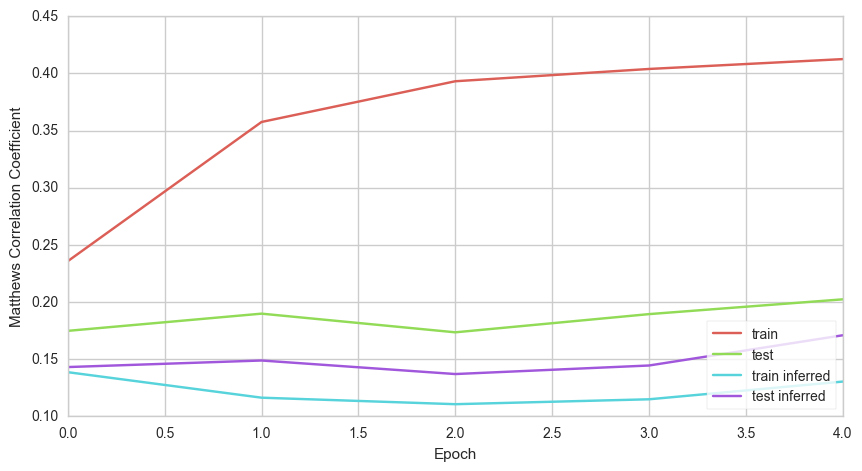

In [10]:
plot_training(model_scores[0], ["train", "test", "train inferred", "test inferred"], 
              size=(10,5), filename="./plots/training")

In [ ]:
### Train and evaluate a doc2vec model

# estimator for evaluation
clf = sklearn.linear_model.LogisticRegression()
estimator = sklearn.multiclass.OneVsRestClassifier(clf)

# train and evaluate model

# # real setup
# (mean_train_scores, 
#  mean_test_scores, 
#  mean_train_infer_scores, 
#  mean_test_infer_scores) = train_eval_doc2vec_CV(
#     X_train, Y_1hot_train, estimator=estimator,
    
#     steps=150, alpha_start=0.025, alpha_end=0.001, 
#     infer_steps=1000, infer_alpha=0.3, 
#     infer_min_alpha=0.005,
#     dm=0, size=300, window=10, negative=3, 
#     min_count=2, hs=0, workers=4, 
#     sample=1e-5, iter=10)


# demo setup
scores = train_eval_doc2vec_CV(
    X_train, Y_1hot_train, estimator=estimator,
    folds=2,
    steps=5, alpha_start=0.025, alpha_end=0.001, 
    infer_steps=5, infer_alpha=0.3, 
    infer_min_alpha=0.005,
    dm=0, size=300, window=10, negative=3, 
    min_count=2, hs=0, workers=4, 
    sample=1e-5, iter=10)

In [ ]:
plot_training(scores, ["train", "test", "train inferred", "test inferred"], 
              size=(10,5), filename="./plots/training")